<a href="https://colab.research.google.com/github/TEhyeok/Vicon/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 구글 드라이브 연결

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# /content/drive/MyDrive/JS_DATA/HAG/HMO/Lt Landing 01.csv 연결
# 데이터 정리 및 요약

import pandas as pd
from google.colab import drive

file_path = '/content/drive/MyDrive/JS_DATA/HAG/LJS/Lt Landing 01.csv'

try:
  df = pd.read_csv(file_path, encoding='utf-8', engine='python') # Try cp949 encoding first, common for Korean CSV
except UnicodeDecodeError:
  try:
    df = pd.read_csv(file_path, encoding='utf-8', engine='python') # Try utf-8 if cp949 fails
  except UnicodeDecodeError:
    print("Error: Could not decode file with cp949 or utf-8 encoding.")
    # Handle other encodings if needed, or raise the exception
    raise
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    # You might want to exit the program or handle this differently
    exit()
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    exit()

# print(df.head())

# Display all rows
pd.set_option("display.max_rows", None)
# df



In [3]:
import pandas as pd
from google.colab import drive

def process_csv(file_path):
    try:
        # Read the original CSV file
        df = pd.read_csv(file_path, encoding='utf-8', engine='python')

        # Initialize DataFrames as None
        emg_df = None
        force_df = None
        deg_df = None

        # Find the indices
        devices_index = -1
        model_outputs_index = -1

        for index, value in enumerate(df.iloc[:, 0]):
            if str(value).strip() == 'Devices':
                devices_index = index
            elif str(value).strip() == 'Model Outputs':
                model_outputs_index = index
                break

        if devices_index != -1 and model_outputs_index != -1:
            # Extract upper section (from Devices to Model Outputs)
            upper_df = df.iloc[devices_index:model_outputs_index, :27]

            # Extract deg section (from Model Outputs onwards, limited to 181 columns)
            deg_df = df.iloc[model_outputs_index:, :182]  # 182 because :182 will include column 181

            # Create EMG file: columns 0,1 combined with 11-26
            cols_emg = list(range(0,2)) + list(range(11,27))
            emg_df = upper_df.iloc[:, cols_emg]

            # Create Force file: columns 0,1 combined with 2-10
            cols_force = list(range(0,2)) + list(range(2,11))
            force_df = upper_df.iloc[:, cols_force]

            # Define output paths
            base_path = '/'.join(file_path.split('/')[:-1])
            file_name = file_path.split('/')[-1].replace('.csv', '')

            # Save all files
            deg_output = f"{base_path}/{file_name}_deg.csv"
            emg_output = f"{base_path}/{file_name}_emg_cols.csv"
            force_output = f"{base_path}/{file_name}_force_cols.csv"

            deg_df.to_csv(deg_output, index=False, encoding='utf-8-sig')
            emg_df.to_csv(emg_output, index=False, encoding='utf-8-sig')
            force_df.to_csv(force_output, index=False, encoding='utf-8-sig')

            print(f"Successfully processed the CSV file:")
            print(f"1. deg section (columns 0-181) saved to: {deg_output}")
            print(f"2. EMG data (cols 0,1 + 11-26) saved to: {emg_output}")
            print(f"3. Force data (cols 0,1 + 2-10) saved to: {force_output}")

        else:
            if devices_index == -1:
                print("Error: 'Devices' marker not found in the file.")
            if model_outputs_index == -1:
                print("Error: 'Model Outputs' marker not found in the file.")

        # Return all three DataFrames
        return emg_df, force_df, deg_df

    except UnicodeDecodeError:
        print("Error: Unable to decode the file with the specified encoding.")
        return None, None, None
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None, None, None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None, None, None

# Usage
file_path = '/content/drive/MyDrive/JS_DATA/HAG/LJS/Lt Landing 01.csv'
emg_df, force_df, deg_df = process_csv(file_path)

# Now you can use these DataFrames separately
if emg_df is not None:
    print("\nEMG DataFrame shape:", emg_df.shape)
if force_df is not None:
    print("Force DataFrame shape:", force_df.shape)
if deg_df is not None:
    print("deg DataFrame shape:", deg_df.shape)

Successfully processed the CSV file:
1. deg section (columns 0-181) saved to: /content/drive/MyDrive/JS_DATA/HAG/LJS/Lt Landing 01_deg.csv
2. EMG data (cols 0,1 + 11-26) saved to: /content/drive/MyDrive/JS_DATA/HAG/LJS/Lt Landing 01_emg_cols.csv
3. Force data (cols 0,1 + 2-10) saved to: /content/drive/MyDrive/JS_DATA/HAG/LJS/Lt Landing 01_force_cols.csv

EMG DataFrame shape: (233, 18)
Force DataFrame shape: (233, 11)
deg DataFrame shape: (16, 182)


In [4]:
# 2행의 값들과 추가 위치의 값들 찾기
row_index = 2
value_sets = {}  # 임시로 저장할 딕셔너리

for col_index, value in enumerate(deg_df.iloc[row_index]):
   if pd.notna(value):  # 모든 값 처리
       xyz_values = []  # X, Y, Z 값을 저장할 리스트

       # Frame 번호 가져오기 (0열의 해당 행 값)
       try:
           frame_number = deg_df.iloc[row_index + 3, 0]  # 0열의 frame 번호
           if pd.isna(frame_number):  # frame 번호가 없으면 건너뛰기
               continue
       except IndexError:
           continue

       # 행+3, 열+0,+1,+2에서 X,Y,Z 값 가져오기
       all_values_exist = True  # 모든 값이 존재하는지 확인하는 플래그
       for col_offset in [0, 1, 2]:
           try:
               additional_value = deg_df.iloc[row_index + 3, col_index + col_offset]
               if pd.notna(additional_value):
                   xyz_values.append(additional_value)
               else:
                   all_values_exist = False
                   break
           except IndexError:
               all_values_exist = False
               break

       # 모든 값이 존재할 때만 추가
       if all_values_exist:
           # 'LJS:'로 시작하는 경우와 그렇지 않은 경우 처리
           if str(value).startswith('LJS:'):
               var_name = str(value).replace('LJS:', '')
           else:
               var_name = str(value).replace(" ", "_").replace("-", "_").replace(".", "_")

           # 이미 변수가 존재하면 튜플에 추가, 아니면 새로 생성
           if var_name not in value_sets:
               value_sets[var_name] = []

           # (frame_number, (x,y,z)) 형태로 추가
           value_sets[var_name].append((frame_number, tuple(xyz_values)))

# 각 변수의 데이터를 frame_number 기준으로 정렬
for var_name in value_sets:
   value_sets[var_name].sort(key=lambda x: x[0])  # frame_number로 정렬

# 변수를 전역 네임스페이스에 추가
for var_name, values in value_sets.items():
   globals()[var_name] = tuple(values)

# 생성된 변수들 확인
print("\n=== 생성된 변수별 값 ===\n")
for var_name, values in value_sets.items():
   print(f"{var_name} = {tuple(values)}")


=== 생성된 변수별 값 ===

LAbsAnkleAngle = (('231', ('-8.61336', '0', '0')),)
LAnkleAngles = (('231', ('-10.7397', '-16.4938', '36.5161')),)
LAnkleForce = (('231', ('2.60164', '0.98003', '1.01536')),)
LAnkleMoment = (('231', ('215.993', '41.1994', '96.2079')),)
LAnklePower = (('231', ('0', '0', '-2.33984')),)
LFE = (('231', ('9.47547', '-15.5464', '124.615')),)
LFO = (('231', ('-85.6977', '133.048', '-161.9')),)
LFootProgressAngles = (('231', ('-79.9505', '26.599', '-1.82013')),)
LGroundReactionForce = (('231', ('-0.238383', '-0.619783', '3.56788')),)
LGroundReactionMoment = (('231', ('71.5413', '108.147', '24.7657')),)
LHipAngles = (('231', ('26.3654', '-18.7643', '-47.4653')),)
LHipForce = (('231', ('0.760895', '-0.483605', '2.71582')),)
LHipMoment = (('231', ('-465.729', '-469.302', '6.8988')),)
LHipPower = (('231', ('0', '0', '1.29631')),)
LKneeAngles = (('231', ('15.7037', '-5.61383', '-5.14291')),)
LKneeForce = (('231', ('0.61525', '-0.821522', '-0.548356')),)
LKneeMoment = (('231', ('

In [5]:
# Frame 번호와 데이터를 수집하는 함수
def collect_data_for_row(df, base_row, frame_col=0, data_row_offset=3):
   value_sets = {}  # 임시로 저장할 딕셔너리

   # 모든 프레임 번호 수집
   frame_numbers = df.iloc[base_row+data_row_offset:, frame_col].dropna()

   # 각 열에 대해 처리
   for col_index, value in enumerate(df.iloc[base_row]):
       if pd.notna(value):  # 모든 값 처리
           # 변수 이름 설정
           if str(value).startswith('LJS:'):
               var_name = str(value).replace('LJS:', '')
           else:
               var_name = str(value).replace(" ", "_").replace("-", "_").replace(".", "_")

           value_sets[var_name] = []

           # 각 프레임에 대해 xyz 값 수집
           for frame_idx, frame_number in enumerate(frame_numbers):
               xyz_values = []
               row_idx = base_row + data_row_offset + frame_idx

               # xyz 값 수집
               all_values_exist = True
               for col_offset in [0, 1, 2]:
                   try:
                       if col_index + col_offset < len(df.columns):
                           additional_value = df.iloc[row_idx, col_index + col_offset]
                           if pd.notna(additional_value):
                               xyz_values.append(additional_value)
                           else:
                               all_values_exist = False
                               break
                       else:
                           all_values_exist = False
                           break
                   except IndexError:
                       all_values_exist = False
                       break

               if all_values_exist:
                   value_sets[var_name].append((frame_number, tuple(xyz_values)))

   return value_sets

# 두 행의 데이터 수집
row_2_data = collect_data_for_row(deg_df, 2)  # 2행 데이터
row_3_data = collect_data_for_row(deg_df, 3)  # 3행 데이터

# 모든 데이터를 전역 변수로 설정
for data_set in [row_2_data, row_3_data]:
   for var_name, values in data_set.items():
       if values:  # 빈 리스트가 아닌 경우만 처리
           globals()[var_name] = tuple(values)

# 생성된 변수들 확인
print("\n=== 2행 변수들 ===\n")
for var_name, values in row_2_data.items():
   if values:  # 빈 리스트가 아닌 경우만 출력
       print(f"{var_name}:")
       print(f"데이터 개수: {len(values)}")
       print(f"첫 번째 항목: {values[0]}")
       print("---")

print("\n=== 3행 변수들 ===\n")
for var_name, values in row_3_data.items():
   if values:  # 빈 리스트가 아닌 경우만 출력
       print(f"{var_name}:")
       print(f"데이터 개수: {len(values)}")
       print(f"첫 번째 항목: {values[0]}")
       print("---")


=== 2행 변수들 ===

LAbsAnkleAngle:
데이터 개수: 11
첫 번째 항목: ('231', ('-8.61336', '0', '0'))
---
LAnkleAngles:
데이터 개수: 11
첫 번째 항목: ('231', ('-10.7397', '-16.4938', '36.5161'))
---
LAnkleForce:
데이터 개수: 11
첫 번째 항목: ('231', ('2.60164', '0.98003', '1.01536'))
---
LAnkleMoment:
데이터 개수: 11
첫 번째 항목: ('231', ('215.993', '41.1994', '96.2079'))
---
LAnklePower:
데이터 개수: 11
첫 번째 항목: ('231', ('0', '0', '-2.33984'))
---
LFE:
데이터 개수: 11
첫 번째 항목: ('231', ('9.47547', '-15.5464', '124.615'))
---
LFO:
데이터 개수: 11
첫 번째 항목: ('231', ('-85.6977', '133.048', '-161.9'))
---
LFootProgressAngles:
데이터 개수: 11
첫 번째 항목: ('231', ('-79.9505', '26.599', '-1.82013'))
---
LGroundReactionForce:
데이터 개수: 11
첫 번째 항목: ('231', ('-0.238383', '-0.619783', '3.56788'))
---
LGroundReactionMoment:
데이터 개수: 11
첫 번째 항목: ('231', ('71.5413', '108.147', '24.7657'))
---
LHipAngles:
데이터 개수: 11
첫 번째 항목: ('231', ('26.3654', '-18.7643', '-47.4653'))
---
LHipForce:
데이터 개수: 11
첫 번째 항목: ('231', ('0.760895', '-0.483605', '2.71582'))
---
LHipMoment:
데이터 개수:

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_xyz_graphs(data_tuple):
   var_name = [k for k,v in globals().items() if v is data_tuple][0]  # 변수 이름 자동으로 찾기

   # 데이터 분리
   frames = [float(item[0]) for item in data_tuple]
   x_values = [float(item[1][0]) for item in data_tuple]
   y_values = [float(item[1][1]) for item in data_tuple]
   z_values = [float(item[1][2]) for item in data_tuple]

   # 그래프 생성
   fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))
   fig.suptitle(f'{var_name} - Angle Values over Frames', fontsize=16)

   # X값 그래프
   ax1.plot(frames, x_values, 'r-', label='X angle')
   ax1.set_ylabel('X Angle (degrees)')
   ax1.grid(True)
   ax1.legend()
   ax1.set_xticks(frames)  # 모든 프레임 표시

   # Y값 그래프
   ax2.plot(frames, y_values, 'g-', label='Y angle')
   ax2.set_ylabel('Y Angle (degrees)')
   ax2.grid(True)
   ax2.legend()
   ax2.set_xticks(frames)  # 모든 프레임 표시

   # Z값 그래프
   ax3.plot(frames, z_values, 'b-', label='Z angle')
   ax3.set_xlabel('Frames')
   ax3.set_ylabel('Z Angle (degrees)')
   ax3.grid(True)
   ax3.legend()
   ax3.set_xticks(frames)  # 모든 프레임 표시

   # 통계 정보 표시
   fig.text(0.02, 0.98, f'X - min: {min(x_values):.2f}°, max: {max(x_values):.2f}°, mean: {np.mean(x_values):.2f}°', fontsize=8)
   fig.text(0.02, 0.96, f'Y - min: {min(y_values):.2f}°, max: {max(y_values):.2f}°, mean: {np.mean(y_values):.2f}°', fontsize=8)
   fig.text(0.02, 0.94, f'Z - min: {min(z_values):.2f}°, max: {max(z_values):.2f}°, mean: {np.mean(z_values):.2f}°', fontsize=8)

   # 그래프 간격 조정
   plt.tight_layout()
   plt.show()

# 사용 예시:
# plot_xyz_graphs(LAbsAnkleAngle)  # 변수 이름만 입력

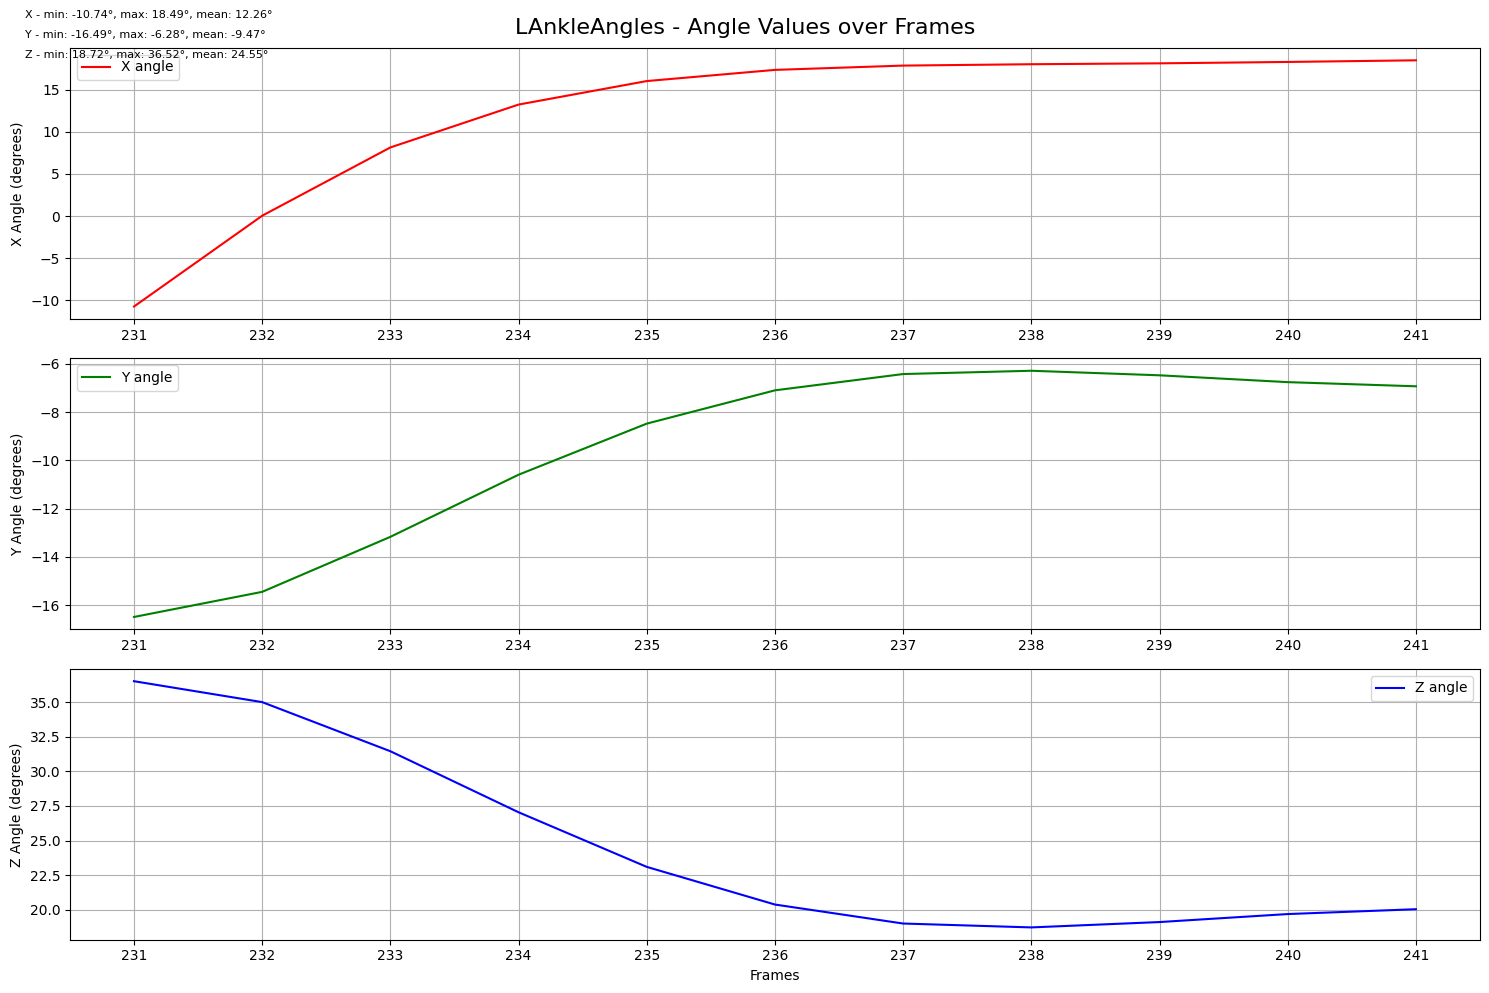

In [7]:
plot_xyz_graphs(LAnkleAngles)

In [8]:
def collect_force_data(force_df, base_row, frame_col=0, subframe_col=1, data_row_offset=3):
    value_sets = {}

    # Get frame and subframe numbers
    start_idx = base_row + data_row_offset
    frame_data = force_df.iloc[start_idx:, :]

    # Get the column names for frame and subframe
    frame_col_name = force_df.columns[frame_col]
    subframe_col_name = force_df.columns[subframe_col]

    # Create frame labels for x-axis
    frame_labels = []
    for idx in range(len(frame_data)):
        frame_val = frame_data.iloc[idx][frame_col_name]
        subframe_val = frame_data.iloc[idx][subframe_col_name]

        if pd.notna(frame_val):  # Only process if frame_val is not NaN
            if pd.notna(subframe_val):
                frame_labels.append(f"{int(frame_val)}.{int(subframe_val)}")
            else:
                frame_labels.append(f"{int(frame_val)}.0")
        else:
            break  # Stop processing when we hit NaN frame values

    # Create list of indices for plotting (0, 1, 2, ...)
    frame_indices = list(range(len(frame_labels)))

    # Process each column
    for col_index, value in enumerate(force_df.iloc[base_row]):
        if pd.notna(value):
            # Set variable name
            if str(value).startswith('LJS:'):
                var_name = str(value).replace('LJS:', '')
            else:
                var_name = str(value).replace(" ", "").replace("-", "").replace(".", "").replace("#", "Num")

            value_sets[var_name] = []

            # Collect xyz values for each frame
            for frame_idx in range(len(frame_labels)):
                xyz_values = []
                row_idx = base_row + data_row_offset + frame_idx

                # Collect xyz values
                all_values_exist = True
                for col_offset in [0, 1, 2]:
                    try:
                        if col_index + col_offset < len(force_df.columns):
                            additional_value = force_df.iloc[row_idx, col_index + col_offset]
                            if pd.notna(additional_value):
                                xyz_values.append(float(additional_value))
                            else:
                                all_values_exist = False
                                break
                        else:
                            all_values_exist = False
                            break
                    except (IndexError, ValueError):
                        all_values_exist = False
                        break

                if all_values_exist and len(xyz_values) == 3:
                    value_sets[var_name].append((frame_labels[frame_idx], tuple(xyz_values)))

    # Return both the value sets and the frame information
    return value_sets, frame_labels, frame_indices

def plot_force_xyz_graphs(data_dict, title=None):
    if title is None:
        # Try to find variable name automatically
        title = [k for k,v in globals().items() if v is data_dict][0]

    # Get the data from the dictionary
    data = data_dict['data']
    frame_labels = data_dict['frame_labels']
    frames = data_dict['frame_indices']

    # Separate data
    x_values = [float(item[1][0]) for item in data]
    y_values = [float(item[1][1]) for item in data]
    z_values = [float(item[1][2]) for item in data]

    # Create graphs
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))
    fig.suptitle(f'{title} - Force Values over Frames', fontsize=16)

    # X force graph
    ax1.plot(frames, x_values, 'r-', label='X force')
    ax1.set_ylabel('X Force (N)')
    ax1.grid(True)
    ax1.legend()

    # Show only frame numbers (not subframes) on x-axis
    major_frames = []
    major_labels = []
    for i, label in enumerate(frame_labels):
        frame_num = int(label.split('.')[0])
        if i == 0 or frame_num != int(frame_labels[i-1].split('.')[0]):
            major_frames.append(frames[i])
            major_labels.append(str(frame_num))

    ax1.set_xticks(major_frames)
    ax1.set_xticklabels(major_labels, rotation=0)

    # Y force graph
    ax2.plot(frames, y_values, 'g-', label='Y force')
    ax2.set_ylabel('Y Force (N)')
    ax2.grid(True)
    ax2.legend()
    ax2.set_xticks(major_frames)
    ax2.set_xticklabels(major_labels, rotation=0)

    # Z force graph
    ax3.plot(frames, z_values, 'b-', label='Z force')
    ax3.set_xlabel('Frames')
    ax3.set_ylabel('Z Force (N)')
    ax3.grid(True)
    ax3.legend()
    ax3.set_xticks(major_frames)
    ax3.set_xticklabels(major_labels, rotation=0)

    # Display statistics
    fig.text(0.02, 0.98, f'X - min: {min(x_values):.2f}N, max: {max(x_values):.2f}N, mean: {np.mean(x_values):.2f}N', fontsize=8)
    fig.text(0.02, 0.96, f'Y - min: {min(y_values):.2f}N, max: {max(y_values):.2f}N, mean: {np.mean(y_values):.2f}N', fontsize=8)
    fig.text(0.02, 0.94, f'Z - min: {min(z_values):.2f}N, max: {max(z_values):.2f}N, mean: {np.mean(z_values):.2f}N', fontsize=8)

    # Adjust layout to prevent label cutoff
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Process force data
row_2_force_data, row_2_labels, row_2_indices = collect_force_data(force_df, 2)
row_3_force_data, row_3_labels, row_3_indices = collect_force_data(force_df, 3)

# Set global variables for force data
for data_set in [row_2_force_data, row_3_force_data]:
    for var_name, values in data_set.items():
        if values:  # Only process non-empty lists
            globals()[var_name] = {
                'data': tuple(values),
                'frame_labels': row_2_labels if data_set is row_2_force_data else row_3_labels,
                'frame_indices': row_2_indices if data_set is row_2_force_data else row_3_indices
            }

# Print available force variables
print("\n=== Force Variables ===\n")
for data_set in [row_2_force_data, row_3_force_data]:
    for var_name, values in data_set.items():
        if values:
            print(f"{var_name}:")
            print(f"Number of data points: {len(values)}")
            print(f"First item: {values[0]}")
            print("---")


=== Force Variables ===

ImportedAMTI400600Num2Force:
Number of data points: 227
First item: ('230.13', (0.939025, -3.25347, -21.8353))
---
ImportedAMTI400600Num2Moment:
Number of data points: 227
First item: ('230.13', (-1733.63, -391.2, -136.181))
---
ImportedAMTI400600Num2CoP:
Number of data points: 227
First item: ('230.13', (182.084, 379.396, 0.0))
---
Frame:
Number of data points: 226
First item: ('230.14', (230.0, 14.0, 1.87805))
---
SubFrame:
Number of data points: 226
First item: ('230.14', (14.0, 1.87805, -6.50694))
---
Fx:
Number of data points: 226
First item: ('230.14', (1.87805, -6.50694, -43.6706))
---
Fy:
Number of data points: 226
First item: ('230.14', (-6.50694, -43.6706, -3467.26))
---
Fz:
Number of data points: 226
First item: ('230.14', (-43.6706, -3467.26, -782.399))
---
Mx:
Number of data points: 226
First item: ('230.14', (-3467.26, -782.399, -272.362))
---
My:
Number of data points: 226
First item: ('230.14', (-782.399, -272.362, 182.084))
---
Mz:
Number of d

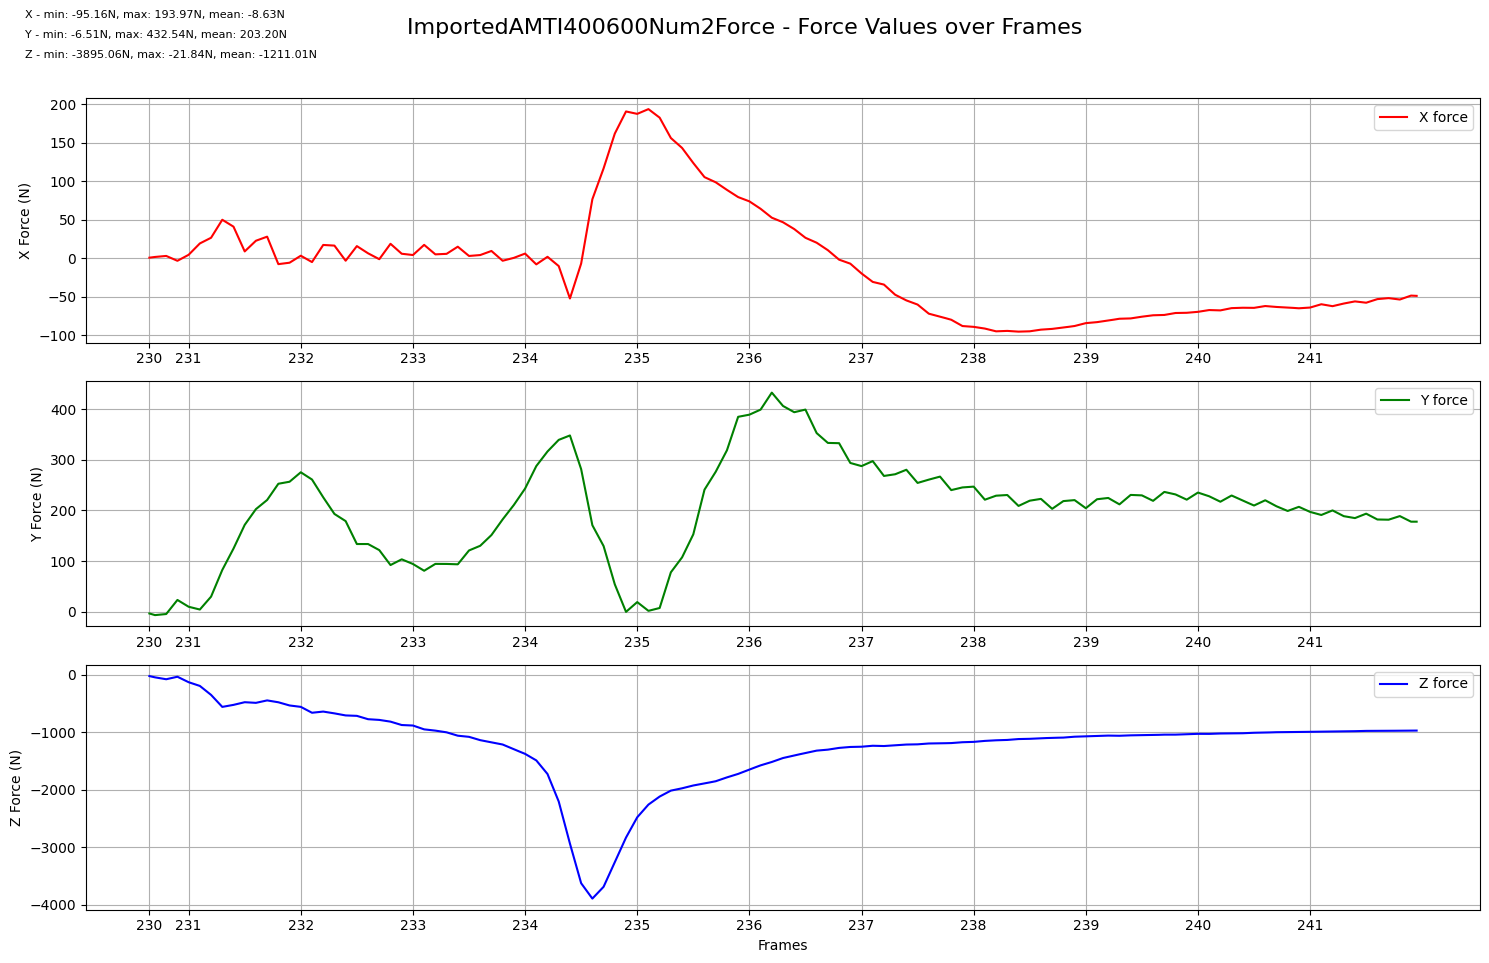

In [9]:
plot_force_xyz_graphs(ImportedAMTI400600Num2Force)

In [10]:
def collect_emg_data(emg_df, base_row, frame_col=0, subframe_col=1, data_row_offset=3):
    value_sets = {}

    # Get frame and subframe numbers
    start_idx = base_row + data_row_offset
    frame_data = emg_df.iloc[start_idx:, :]

    # Get the column names for frame and subframe
    frame_col_name = emg_df.columns[frame_col]
    subframe_col_name = emg_df.columns[subframe_col]

    # Create frame labels for x-axis
    frame_labels = []
    for idx in range(len(frame_data)):
        frame_val = frame_data.iloc[idx][frame_col_name]
        subframe_val = frame_data.iloc[idx][subframe_col_name]

        if pd.notna(frame_val):  # Only process if frame_val is not NaN
            if pd.notna(subframe_val):
                frame_labels.append(f"{int(frame_val)}.{int(subframe_val)}")
            else:
                frame_labels.append(f"{int(frame_val)}.0")
        else:
            break  # Stop processing when we hit NaN frame values

    # Create list of indices for plotting (0, 1, 2, ...)
    frame_indices = list(range(len(frame_labels)))

    # Process each column
    for col_index, value in enumerate(emg_df.iloc[base_row]):
        if pd.notna(value):
            # Set variable name
            if 'Delsys EMG' in str(value) and 'Sensor' in str(value):
                # Extract sensor number and create simple name (e.g., EMG10)
                sensor_num = str(value).split('Sensor')[-1].strip()
                var_name = f'EMG{sensor_num}'
            else:
                continue  # Skip non-EMG columns

            value_sets[var_name] = []

            # Collect EMG values for each frame
            for frame_idx in range(len(frame_labels)):
                row_idx = base_row + data_row_offset + frame_idx
                try:
                    emg_value = emg_df.iloc[row_idx, col_index]
                    if pd.notna(emg_value):
                        value_sets[var_name].append((frame_labels[frame_idx], float(emg_value)))
                except (IndexError, ValueError):
                    break

    return value_sets, frame_labels, frame_indices

def plot_emg_graph(data_dict, title=None):
    if title is None:
        # Try to find variable name automatically
        title = [k for k,v in globals().items() if v is data_dict][0]

    # Get the data from the dictionary
    data = data_dict['data']
    frame_labels = data_dict['frame_labels']
    frames = data_dict['frame_indices']

    # Get EMG values and convert to mV (multiply by 1000)
    emg_values = [float(item[1]) * 1000 for item in data]

    # Create graph
    fig, ax = plt.subplots(figsize=(15, 6))
    fig.suptitle(f'{title} - EMG Values over Frames', fontsize=16)

    # Show only frame numbers (not subframes) on x-axis
    major_frames = []
    major_labels = []
    for i, label in enumerate(frame_labels):
        frame_num = int(label.split('.')[0])
        if i == 0 or frame_num != int(frame_labels[i-1].split('.')[0]):
            major_frames.append(frames[i])
            major_labels.append(str(frame_num))

    # Plot EMG values
    ax.plot(frames, emg_values, 'b-', label='EMG Signal')
    ax.set_xlabel('Frames')
    ax.set_ylabel('EMG (mV)')
    ax.grid(True)
    ax.legend()
    ax.set_xticks(major_frames)
    ax.set_xticklabels(major_labels, rotation=0)

    # Calculate statistics
    min_val = round(min(emg_values), 3)
    max_val = round(max(emg_values), 3)
    mean_val = round(np.mean(emg_values), 3)
    std_val = round(np.std(emg_values), 3)

    # Add statistics text box
    stats_text = (f'Statistics:\n'
                 f'Min: {min_val:.3f} mV\n'
                 f'Max: {max_val:.3f} mV\n'
                 f'Mean: {mean_val:.3f} mV\n'
                 f'SD: {std_val:.3f} mV')

    # Place text box in upper right corner with light blue background
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
    ax.text(0.98, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=props)

    # Adjust layout to prevent label cutoff
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Process EMG data
row_2_emg_data, row_2_labels, row_2_indices = collect_emg_data(emg_df, 2)
row_3_emg_data, row_3_labels, row_3_indices = collect_emg_data(emg_df, 3)

# Set global variables for EMG data
for data_set in [row_2_emg_data, row_3_emg_data]:
    for var_name, values in data_set.items():
        if values:  # Only process non-empty lists
            globals()[var_name] = {
                'data': tuple(values),
                'frame_labels': row_2_labels if data_set is row_2_emg_data else row_3_labels,
                'frame_indices': row_2_indices if data_set is row_2_emg_data else row_3_indices
            }

# Print available EMG variables
print("\n=== EMG Variables ===\n")
for data_set in [row_2_emg_data, row_3_emg_data]:
    for var_name, values in data_set.items():
        if values:
            print(f"{var_name}:")
            print(f"Number of data points: {len(values)}")
            print(f"First item: {values[0]}")
            print("---")


=== EMG Variables ===

EMG1:
Number of data points: 227
First item: ('230.13', 0.0)
---
EMG2:
Number of data points: 227
First item: ('230.13', 0.0)
---
EMG3:
Number of data points: 227
First item: ('230.13', 0.0)
---
EMG4:
Number of data points: 227
First item: ('230.13', 0.0)
---
EMG5:
Number of data points: 227
First item: ('230.13', 0.0)
---
EMG6:
Number of data points: 227
First item: ('230.13', 0.0)
---
EMG7:
Number of data points: 227
First item: ('230.13', 0.0)
---
EMG8:
Number of data points: 227
First item: ('230.13', 0.0)
---
EMG9:
Number of data points: 227
First item: ('230.13', 0.0)
---
EMG10:
Number of data points: 227
First item: ('230.13', -0.00109812)
---
EMG11:
Number of data points: 227
First item: ('230.13', 0.000589751)
---
EMG12:
Number of data points: 227
First item: ('230.13', -0.000156661)
---
EMG13:
Number of data points: 227
First item: ('230.13', 5.39e-05)
---
EMG14:
Number of data points: 227
First item: ('230.13', 5.13e-05)
---
EMG15:
Number of data poin

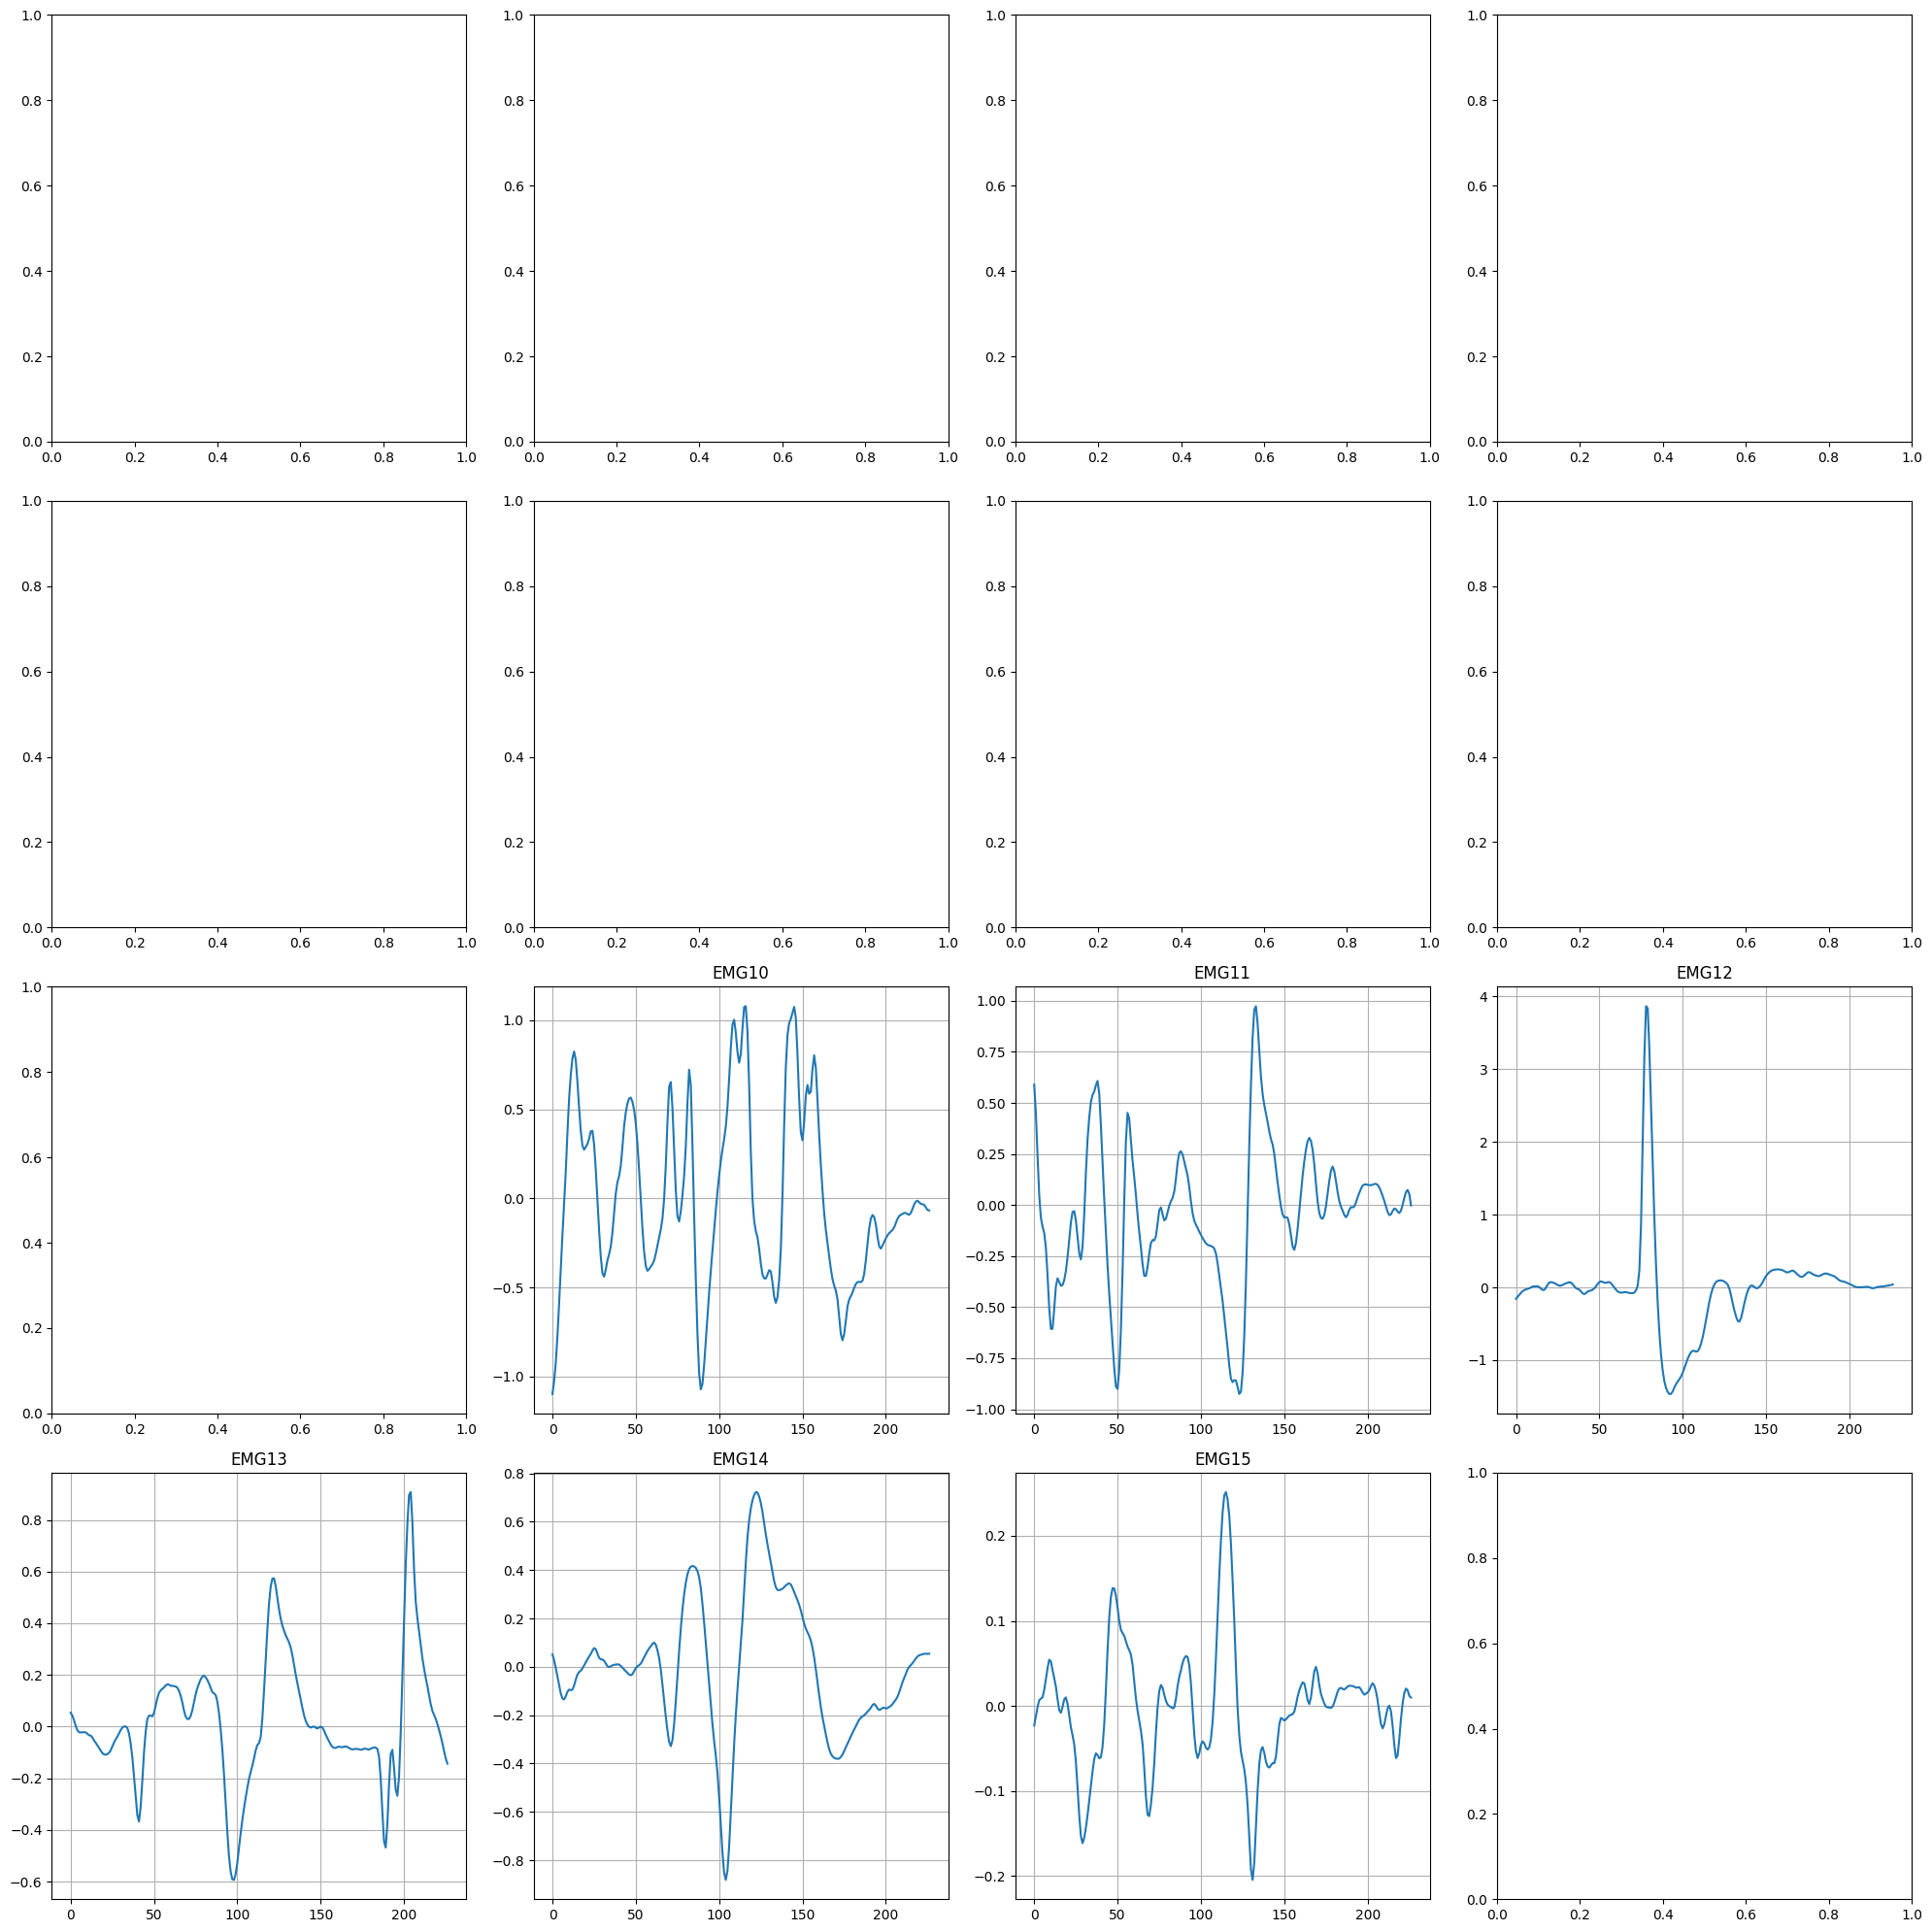

In [11]:
# prompt: EMG1 ~EMG16까지 출력
# 이때 값이 0이면 그래프 그리지 말자
# 그래프 크기를 1/4로 줄여서 격자 형태로 배치

import matplotlib.pyplot as plt

# Assuming EMG1 to EMG16 are defined as dictionaries like other variables
emg_variables = [var for var in globals() if var.startswith('EMG') and isinstance(globals()[var], dict)]

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 20))  # Adjust figsize as needed

for i, emg_var in enumerate(emg_variables):
    if i < 16:  # Ensure we don't exceed the number of subplots
        row = i // 4
        col = i % 4
        ax = axes[row, col]

        try:
          emg_data = globals()[emg_var]
          emg_values = [float(item[1]) * 1000 for item in emg_data['data']]
          if any(emg_values):  # Check if any EMG values are not zero
              frames = emg_data['frame_indices']
              ax.plot(frames, emg_values)
              ax.set_title(emg_var)
              ax.grid(True)
        except (KeyError, IndexError, TypeError):
          # Handle cases where the emg variable is not properly defined
          print(f"Warning: Could not plot {emg_var}. Check if the variable is defined correctly.")

# Remove unused subplots
for i in range(len(emg_variables), 16):
    row = i // 4
    col = i % 4
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()
